# Assignment 3

## Angelo Rosace

**ATP Production**

We got a set of results form a research concerning ATP production. The researchers conducting this research inferred a model explaining the process from the data collected.

The model is defined as follows:

**ATP = a * Proteins + b * Carbohydrates + c * Fats + ε**

We know that each value of Protein, Carbohydrates and Fats value is relative to a maximum established by the researchers. They are chosen in a random fashion to give as a diet to the patients.
The distributions for them are:

- Proteins ~ Uniform(0,1)
- Carbohydrates ~ Uniform(0,1)
- Fats ~ Uniform(0,1)

**1. Write a python script that construct the model that we were investigating in pyMC3.**

In [1]:
import pymc3 as pm
import pandas as pd
import seaborn as sn

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


First of all let's read our data and inspect them.

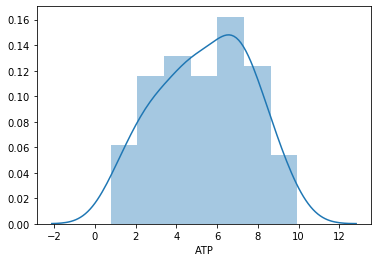

In [2]:
diet_and_atp = pd.read_csv("diet_and_atp.tsv", sep = "\t", header = [0])
atp = diet_and_atp["ATP"]
prot = diet_and_atp["Protein"]
carb = diet_and_atp["Carbohydrates"]
fat = diet_and_atp["Fat"]
sn.distplot(atp, label="ATP")

The plot above represent the distribuion of the ATP as described by our data set. As we can see the distribution seems to follow a normal distribution. This means that in order to construct a model for this biological process we will take in consideration two main variables: the mean and the standard deviation.

In order to make some educated guesses for describing the model I will analyze my data.
First of all I am interested in seing how much the atp value fluctuates in order to have an idea about the standard deviation of the model.

In [3]:
print("The maximum value for the atp is: ", max(atp), "\nThe minimum value for the atp is: ", min(atp))

The maximum value for the atp is:  9.93 
The minimum value for the atp is:  0.78


I will therefore consider the standard deviation to be following a uniform distribution in a range from 0 to 10.

We now miss the mean of the distribution. For the purpose of this assignment we consider it to be a deterministic variable described by the function that makes up the model.

We also know that our model is influenced by three unknown coeficients: a, b and c.
The researchers already provided us with information about the distributions of the three variables associated with the coeficients and we will use them as our prior beliefs.

Taking in account this pieces of information we can finally construct the model as follows:

In [4]:
with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    a = pm.Normal("a", mu=0, sd=100)
    b = pm.Normal("b", mu=0, sd=100)
    c = pm.Normal("c", mu=0, sd=100)
    #a = pm.Uniform("a", 0, 1)
    #b = pm.Uniform("b", 0, 1)
    #c = pm.Uniform("c", 0, 1)
    
    mean = pm.Deterministic("mean", a*prot + b*carb + c*fat)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=atp)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [c]
>Metropolis: [b]
>Metropolis: [a]
>Metropolis: [std]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [09:08<00:00, 733.41draws/s]
The number of effective samples is smaller than 10% for some parameters.


/srv/conda/envs/notebook/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/srv/conda/envs/notebook/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/srv/conda/envs/notebook/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/srv/conda/envs/notebook/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied

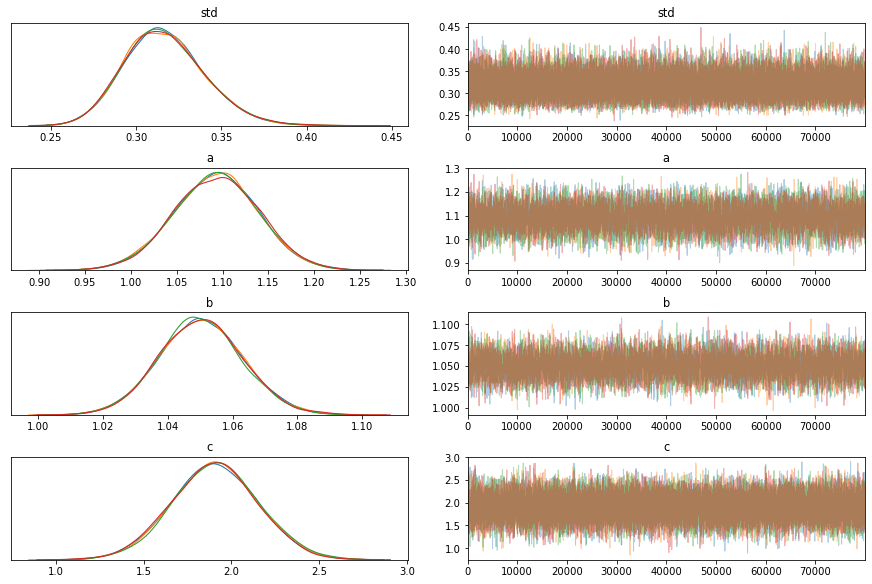

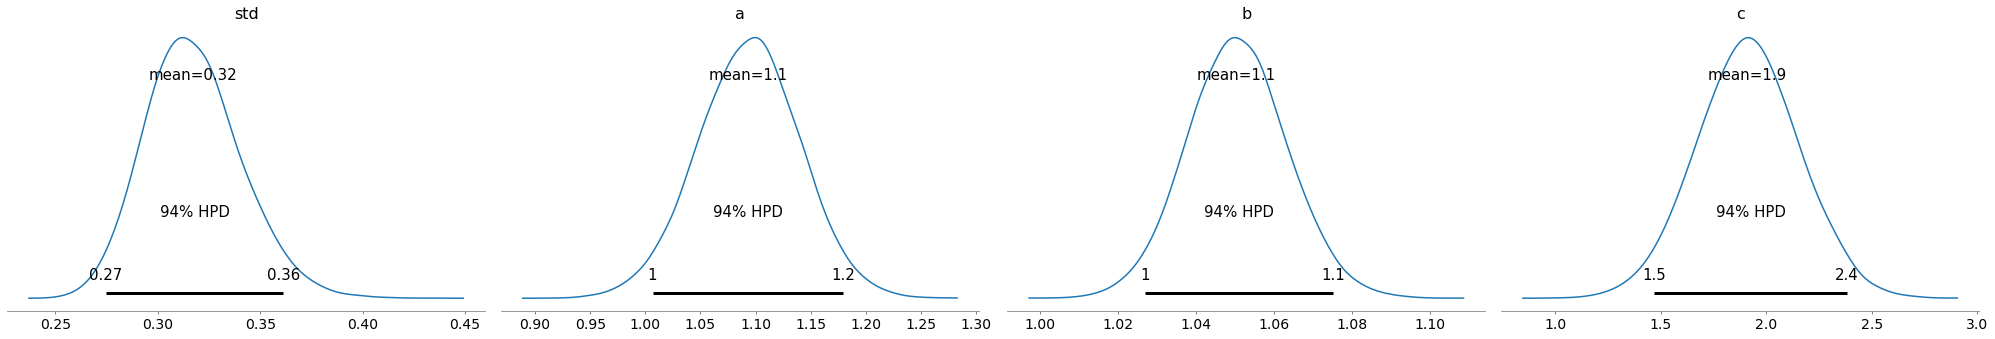

In [6]:
pm.plots.traceplot(burned_trace, varnames=["std", "a", "b","c"])
pm.plot_posterior(burned_trace, varnames=["std", "a", "b","c"]);